In [18]:
import findspark
findspark.init()

import pyspark
import logging
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark import SparkConf, SparkContext
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


## Задача валидации моделей и провести АВ тест для сравнения двух моделей
Для валидации я использовал метрику F1, изначально отбирал модели котрые находили хоть одну мошенническую транзакцию, большинство ни нашли ни одной(
Я взял одну тестовую выборку о транзакциях и применил к ней 2 модели, потом сравнил

Н0: модели дают одинаковый результат

In [35]:
def f1_score(predictions):
    '''Подсчёто метрики F1 для предсказаний модели
       на вохд предсказания с колонками tx_fraud - лейблы, prediction - ответы модели
    '''
    tp = predictions.filter((F.col("tx_fraud") == 1) & (F.col("prediction") == 1)).count()
    tn = predictions.filter((F.col("tx_fraud") == 0) & (F.col("prediction") == 0)).count()
    fp = predictions.filter((F.col("tx_fraud") == 0) & (F.col("prediction") == 1)).count()
    fn = predictions.filter((F.col("tx_fraud") == 1) & (F.col("prediction") == 0)).count()
    
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*(prec*rec)/(prec+rec)
    return f1

In [19]:
spark = (
    SparkSession
    .builder
    .appName("antiFraud")
    .config("spark.ui.port", "4040")
    .getOrCreate()
)

In [39]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [31]:
df = spark.read.parquet("/user/data_clean/df.parquet").fillna(0)

### У меня есть 2 модели:  
    А - DecisionTreeClassifier взял базовые параметры sparkML  
    B - DecisionTreeClassifier изменил параметр maxDepth = 7

In [29]:
modelA = PipelineModel.load("/user/models/tree/sparkml") #/user/models/tree_md7/sparkml
modelB = PipelineModel.load("/user/models/tree_md7/sparkml")

Мне тут нужны только тестовые данные, разбил с рандомсидом как при обучении моделей

In [32]:
splits = df.randomSplit([0.9, 0.1], 42)
training = splits[0]
test = splits[1]

In [ ]:
# splitGroups = test.randomSplit([0.5, 0.5], 42)
# groupA = splitGroups[0]
# groupB = splitGroups[1]

### Предсказания каждой модели на одних и тех же данных, которые они не видели на обчуении

In [44]:
predictionsA = modelA.transform(test).select("transaction_id", "tx_fraud", "prediction")

In [45]:
predictionsB = modelB.transform(test).select("transaction_id", "tx_fraud", "prediction")

In [46]:
predictionsA

transaction_id,tx_fraud,prediction
1413,0,0.0
1670,0,0.0
11253,0,0.0
13904,0,0.0
18554,0,0.0
23071,0,0.0
26312,0,0.0
26524,0,0.0
30497,1,0.0
38213,0,0.0


In [47]:
predictionsA.select('prediction').filter((col("prediction") == 1)).count()

289437

In [48]:
predictionsB.select('prediction').filter((col("prediction") == 1)).count()

725570

In [55]:
import numpy as np
from scipy.stats import mannwhitneyu

Теперь я хочу получить распределения метрики F1 для каждой модели с помощью бутсрапа  

In [53]:
bootstrap_size = 50 # взял всего 50, число никак не рассчитывал, просто чтобы не ждать пол века
sample_size = 0.8 # где-то вычитал что 0.8 вроде норм

In [54]:
f1A = []
f1B = []

In [117]:
for i in range(bootstrap_size):
    sampleA = predictionsA.sample(withReplacement=True, fraction=sample_size)
    f1A.append(f1_score(sampleA))
    
    sampleB = predictionsB.sample(withReplacement=True, fraction=sample_size)
    f1B.append(f1_score(sampleB))

Все 50 выборок я не дождался, пришлось бы ещё раз пополнять баланс 

In [116]:
len(f1A)

28

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
f1A = np.array(f1A)
f1B = np.array(f1B)

Посчитал интервалы 3сигма для полученных распределений

In [64]:
print(f"Модель А. среднее: {f1A.mean()}, интервал: {f1A.mean() - 3*f1A.std()}, {f1A.mean() + 3*f1A.std()}")
print(f"Модель B. среднее: {f1B.mean()}, интервал: {f1B.mean() - 3*f1B.std()}, {f1B.mean() + 3*f1B.std()}")

Модель А. среднее: 0.02723033153664984, интервал: 0.026907453494336542, 0.027553209578963136
Модель B. среднее: 0.0887563952026148, интервал: 0.08840073379434292, 0.08911205661088668


Интервал не перекрывается, вероятно вторая модель лучше  
это также видно на кривом, убогом рисунке ниже

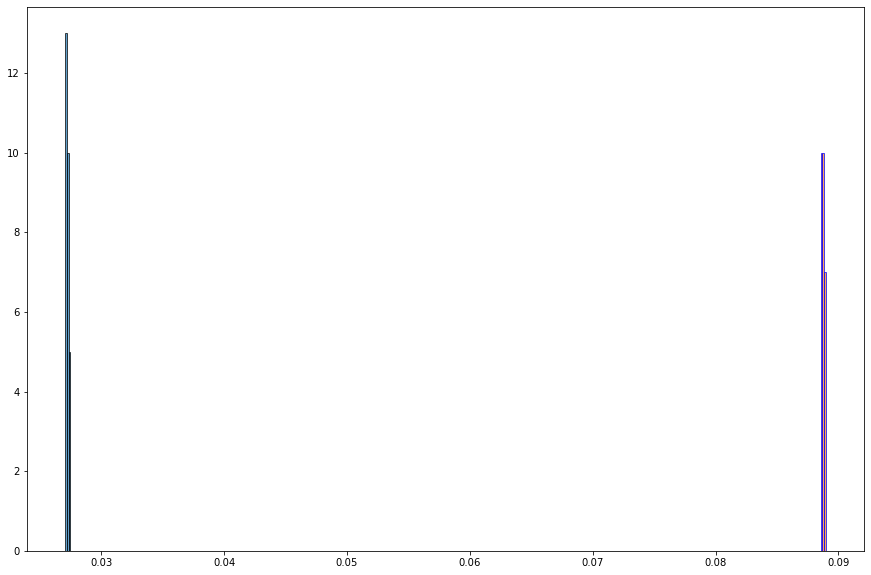

In [107]:
bins = 3
plt.figure(figsize=(15, 10))
plt.hist(f1A, bins=bins, alpha=0.7, edgecolor='black')
plt.hist(f1B, bins=bins, alpha=0.7, edgecolor='blue')
plt.show()

### Критерий Манна-Уитни

In [63]:
from scipy.stats import mannwhitneyu # Импортируем нужный тест из пакета scipy

# Сравнение групп
stat, p = mannwhitneyu(f1A, f1B) # U-тест Манна-Уитни
print('Statistics=%.3f, p=%.3f' % (stat, p))


# Интерпретируем
alpha = 0.05   # Уровень значимости
if p > alpha:
    print('Одинаковые распределения (не отвергаем H0)')
else:
    print('Разные распределения (отвергаем H0)')

Statistics=0.000, p=0.000
Разные распределения (отвергаем H0)


### Вывод
Так как критерий показал что распределения отличаются, а интервавлы не пересекаются и у модели А он ниже,  
<b>Можно предположить что вторая модель "Дерево" с maxDepth=7 лучше</b>